# Encoder - Celltype-Assay embedding model 

This is the first attempt to autoencode the protein assays. This experiment is run on a subset of celltypes and assays which are meaured over chromosome 21, namely:

1. E001-H3K4me1
2. E001-H3K4me3
3. E001-H3K9ac
4. E001-H3K9me3
5. E002-H3K4me1
6. E002-H3K4me3
7. E002-H3K9ac
8. E002-H3K9me3

The model consists of the following:

1. Celltype-Assay embedding layer (CA embedding)

This layer creates an embedding based on the *vocabulary size* i.e number of celltype-assay combinations.

2. Encoder LSTM 

Each protein assay is at 25 base-pair resolution and divided into a sequence of 100 positions and fed into the LSTM. Each positon generates a *hidden state (h)* which is concatenated with the CA embedding and fed into as *cell state (c)* of the decoder at the corresponding positions. Also, the final *hidden state* at the end of 100 positions is concatenated with the CA embedding and initialized as the *hidden state* of the decoder and carried forward as the initial *hidden state* of the encoder for the next 100 positions.     

3. Decoder LSTM

The initialized *hidden states* and *cell states* are used to autoencode the assay at the corresponding 100 positions. 


The details regarding the encoder, decoder and CA embedding size are mentioned in the config file under the *model* directory. The code is in the *src* subdirectory. The tensorboard graphs can be found in the *model/t_log* subdirectory.  

## Observations

1. For most of the CA combinations, the model is predicting a spike at the start of the track (for every 100 track cut). This is peculiar and could be because of the way hidden states are being carried over in the current model. 
2. For the most part the model is able to autoencode well across CA types. It is seen that the predicted signal is slightly lesser than the true signal (about 0.15).
3. One other peculiar behaviour of the model was that it seemed to be agnostic to the CA embedding. The model was able to autoencode well even with mismatch in celltype-assay ID and the actual data, leading me to believe that the model is not learning much from the CA embedding but rather has most of its power in the encoder and decoder.

# Matrix embedding model 

Variations of LSTM models are tried on the data and the Mean Squared Error (MSE) values are reported along with sample test results.

The basic model consists of the following:

1. Encoder LSTM

Each protein assay is at 25 base-pair resolution and divided into a sequence of 100 positions. The 8 assays (not specific to cell type) are stacked on top of each other such that each genomic position can be charectized by the vector of 8 values from these assays. Each positon generates a *hidden state (h)* which is reduced in size (<8) so as to achieve compression, distill noise and create a latent space. The final *hidden state* of the encoder is seeded to the decoder as it's initial *hidden state*. The *cell state (c)* of the encoder at each genomic position is fed into the *cell state (c)* of the decoder at the corresponding position. The final *hidden state* of the encoder is carried forward as the initial *hidden state* of the encoder for the next 100 positions.     

2. Decoder LSTM

The initialized *hidden states* and *cell states* are used to autoencode the assay at the corresponding 100 positions.

## Observations

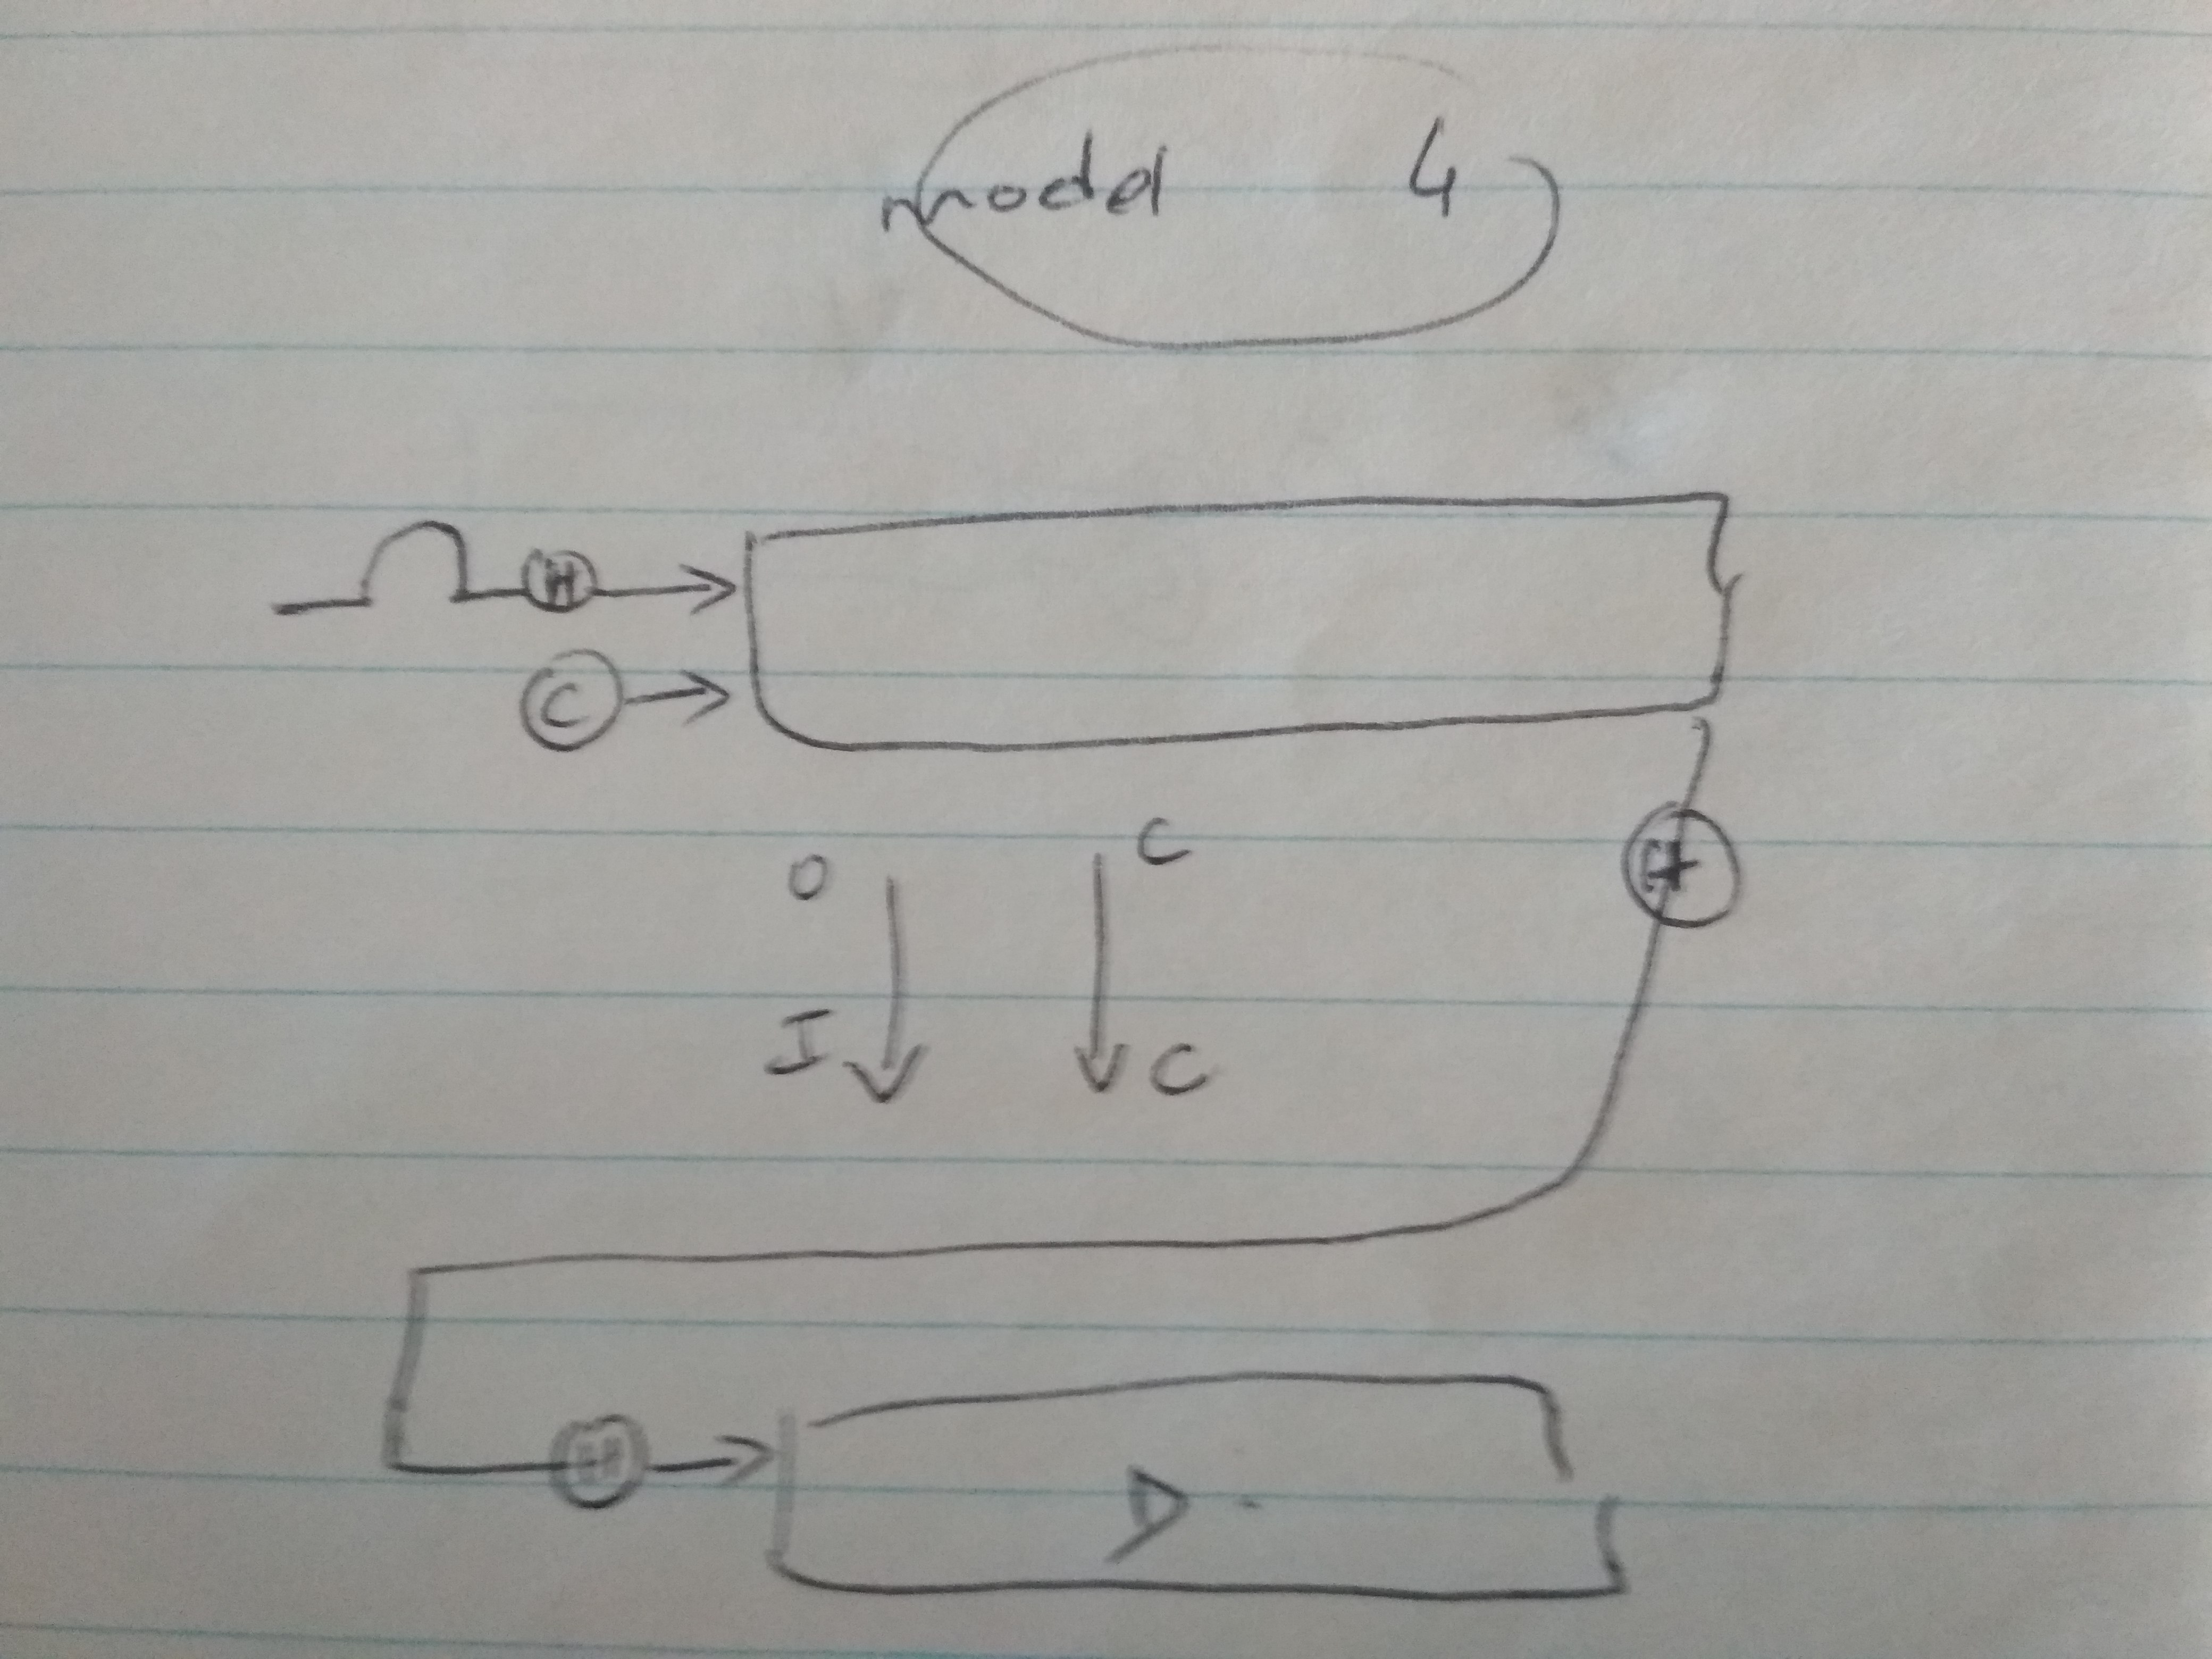

1. Model 4 outperforms the others in terms of MSE. This could be because of:
    * The hidden state being passed over while the cell state is reinitialized. This not only allows information from the previous track to be retained but also makes room for information that is specific to the current track
    * The cell state of the decoder is seeded with the cell state of the encoder at each genomic position
    
2. Increasing the number of hidden dimensions from 3 to 4 has the most significant effect on MSE where MSE decreases from 3.049 1.961.  

3. A learning rate which provides a good tradeoff between MSE and training time can be set. A learning rate of 10-2 provides the best tradeoff. 

4. Some tracks outperform others. If tracks are numbered from 1-8, from top to down and left to right, it is seen that track 2,3,6,8 consistently achieve good MSE across all the models. Tracks 1,4,5,7 on the other hand, do not perform so well. It seems the model is doing well for tracks that have high variability and doing poorly for tracks that are consistently low for many positions. This is because it is easier for the model to learn the mean of low variability tracks and then copy that so as to achieve minimum overall MSE when its restricted by the number of hidden dimensions. 